# Generate point cloud and estimate normals

In [23]:
import open3d as o3d
import numpy as np
import random
from sklearn.neighbors import NearestNeighbors
import pandas as pd
from sklearn.manifold import MDS
from matplotlib import pyplot as plt

In [9]:
# Import the coordinates and the features that have been generated by dMaSIF-site

coords = np.load("1pgb_A_predcoords.npy")
features = np.load("1pgb_A_predfeatures_emb1.npy")


In [10]:
#create a PointCloud and add the points

pointcloud = o3d.geometry.PointCloud()
pointcloud.points = o3d.utility.Vector3dVector(coords)
#o3d.visualization.draw_geometries([pointcloud])

In [11]:
# Estimate the normals based on knn
pointcloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamKNN(knn = 5))
pointcloud.orient_normals_consistent_tangent_plane(k=5)

o3d.visualization.draw_geometries([pointcloud], point_show_normal = True)

In [12]:
#Extract the normals as numpy array
normals = np.asarray(pointcloud.normals)

In [13]:
#Make uniform coloring of pointcloud

colors = np.zeros((len(coords),3))
colors[:,1]= 0.5
colors[:,2]= 1

pointcloud.colors = o3d.utility.Vector3dVector(colors)
#o3d.visualization.draw_geometries([pointcloud])

# Select a center point around which to extract a geodesic patch

In [14]:
#Select a random point of the cloud, around which to draw a geodesic circle, set a geodesic radius
radius = 9
center_index = random.randint(0, len(coords)-1) 
center_coords = coords[center_index]
center_norm = normals[center_index]

In [15]:
center_index, center_coords, center_norm

(4456,
 array([10.746722 , 14.552478 ,  4.4639645], dtype=float32),
 array([ 0.61851208,  0.40198285, -0.67516857]))

# Select all points that are close to the center point and generate a graph

In [16]:
# Make a rough first selection with all points with euclidean distance < radius

first_sel = [center_index] # to save all the points that are within the non-geodesic radius

#loop through all the points and check what their distance to the selected center point is
for index, point in enumerate(coords):
    dist = np.linalg.norm(coords[center_index]-point)

    # select only those points that are close to the center point and calculate their geodesic distance
    if dist < radius and dist != 0:
        first_sel.append(index)
        
coords_sel = coords[first_sel]


In [24]:
def generate_graph(indeces, coords_sel, normals):

    '''Function that takes a set of points, with their label, coordinates and surface normals. Calculates for each point the 
    geodesic distance to its n nearest neighbors and saves that information in a dictionary representing a graph. '''
    
    knn = NearestNeighbors(n_neighbors=4)
    knn.fit(coords_sel)
    graph = {}
    
    #loop through each point that is within the radius and find its nearest neighbors and their euclidean distance
    for idx, point in enumerate(coords_sel):
        dist, neighbors = knn.kneighbors([point], return_distance=True)
        
        # loop through the nearest neighbors calculate their geodesic distance to the point chosen above
        # Add the geodesic distance to a graph-dictionary
        connected_nodes = []
        for index, neighbor in enumerate(neighbors[0]):
            geo_dist = dist[0][index]*(2-np.dot(normals[indeces[idx]], normals[indeces[neighbor]]))        
            #distances.at[ first_sel[idx] , first_sel[neighbor] ] = geo_dist
            if geo_dist !=0:
                connected_nodes.append((indeces[neighbor], geo_dist))

        graph[indeces[idx]]=connected_nodes                      
    
    return graph

In [25]:
graph = generate_graph(first_sel, coords_sel, normals)

In [27]:
def make_graph_bidirectional(graph):  

    '''The result of the generate_graph function is a graph where individual points can be "connected" to another point, but not
    vice-versa. This function detect unidirectional connections and adds the connection information to both involved points'''
    
    #loop through all the keys
    for key in graph:
        
        # loop through all the neighbors of the key and their distances to the key
        for p, d in graph[key]:
            # For each neighbor, set bidirectional = False
            bidirectional = False
            
            # check the graph entry of that neighbor, if there the key is among its connected points, set bidire = True
            for pt,_ in graph[p]:
                if pt == key:
                    bidirectional = True

            if not bidirectional:
                current_list = graph[p]
                current_list.append((key,d))
                graph[p]=current_list
                
    return graph

In [28]:
graph = make_graph_bidirectional(graph)

In [29]:
graph

{4456: [(4454, 0.12499489759147654),
  (4453, 0.3954623471736107),
  (4457, 0.47163823579384817)],
 1910: [(2077, 0.5014716543820478),
  (1912, 0.6063359771912116),
  (2078, 0.6560251305362452)],
 1912: [(2080, 0.4464712557477478),
  (2077, 0.5361853306711517),
  (1910, 0.6063359771912116),
  (1914, 0.7133827372559551)],
 1914: [(2082, 0.611565934926578),
  (1917, 0.6442076790337161),
  (1912, 0.7133827372559551)],
 1917: [(1919, 0.4929532189091633),
  (2084, 0.6213502157799211),
  (1914, 0.6442076790337161)],
 1919: [(1917, 0.4929532189091633),
  (1920, 0.4968393001524706),
  (2086, 0.7876992707928343)],
 1920: [(1926, 0.4395331819939717),
  (1919, 0.4968393001524706),
  (2092, 0.6277302186753507)],
 1926: [(1920, 0.4395331819939717),
  (2092, 0.5047312653807231),
  (1927, 0.6195519080031345),
  (2093, 0.7486058110180738)],
 1927: [(1935, 0.3974123534262161),
  (1926, 0.6195519080031345),
  (2094, 0.6578825825423692)],
 1935: [(1927, 0.3974123534262161),
  (1936, 0.6602022381927309),


# Run dijkstra algorithm on the graph and find the geodesic distance of each node to the center node

In [30]:
def dijkstra(graph, center):
    
    '''Function that takes a graph and the starting node and returns a list of distances 
    from the starting node to every other node'''

    n = len(graph) # How many nodes are in the graph?
    
    # initialize a dictionary to save the distances of each node from the start node
    dist_from_center = {}
    for key in graph:
        dist_from_center[key]=1000
        
    # initialize a dictionary to save which node has been visited already
    visited={}
    for key in graph:
        visited[key]=False
            
    # set the distance for the start to be 0
    dist_from_center[center] = 0
    
    
    
    for p in range(n):
        
        
        # loop through all the nodes to check which one is not yet visited and has the lowest distance to the current node
        u = -1
        for key in graph:
            # if the node 'key' hasn't been visited and
            # we haven't processed it or the distance we have for it is less
            # than the distance we have to the "start" node
            
            # our start node (4557) will be selected first and assigned to u
            if not visited[key] and (u == -1 or dist_from_center[key] < dist_from_center[u]):
                u = key 
        
        
        # all the nodes have been visited or we can't reach this node
        if dist_from_center[u] == 1000:
            #print("break")
            break
        
        # set the node as visited
        visited[u] = True
        
        # from the current selected node u, check what the distances to the next nodes are and update their dist from center
        # loop through all the points (and their weights) that can be reached from our current node
        for v, l in graph[u]:
            if dist_from_center[u] + l < dist_from_center[v]:
                dist_from_center[v] = dist_from_center[u] + l
    return dist_from_center

In [31]:
dist_from_center = dijkstra(graph, center_index)

In [32]:
dist_from_center

{4456: 0,
 1910: 12.471500960575444,
 1912: 12.596026714623541,
 1914: 13.141184843625995,
 1917: 13.68245480009046,
 1919: 13.879089481816166,
 1920: 13.987697863876715,
 1926: 13.864698910582087,
 1927: 14.484250818585222,
 1935: 14.653756158948484,
 1936: 15.141900484647936,
 2074: 11.118872927961329,
 2077: 12.059841383952389,
 2078: 11.8154758300392,
 2080: 12.315752319295466,
 2082: 12.529618908699417,
 2084: 13.061104584310538,
 2086: 13.091390211023333,
 2087: 12.998597522518544,
 2092: 13.359967645201364,
 2093: 13.289209332704976,
 2094: 13.856942675935034,
 2102: 14.492951911565637,
 2103: 14.797797313266736,
 2110: 15.272665996963154,
 2111: 14.493166074686108,
 2114: 14.044041556796188,
 2117: 14.339938853995186,
 2243: 12.595012517918502,
 2249: 11.885316477293925,
 2250: 11.495976064678098,
 2255: 11.366963278212513,
 2256: 10.978988694862142,
 2262: 10.876806549091233,
 2263: 10.514337439952453,
 2268: 11.14730556670056,
 2273: 11.122459438170736,
 2275: 12.018351832234

## Keep only the points that are within the geodesic radius. Use the results of the djikstra algorithm

In [33]:
# Collect the indeces of the points that are < radius away from the center point
patch_indeces = []

for key in dist_from_center:
    if dist_from_center[key]<=radius:
        patch_indeces.append(key)
        
patch_coords = coords[patch_indeces]
patch_features = features[patch_indeces]
patch_normals = normals[patch_indeces]

## Visualize the new geodesic patch

In [34]:
colors[patch_indeces]=np.asarray([1,0.5,0])
colors[center_index]=np.asarray([1,0,0])

In [35]:
pointcloud.colors = o3d.utility.Vector3dVector(colors)
o3d.visualization.draw_geometries([pointcloud])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The handle is invalid. 


In [36]:
#create a visualization of the "patchcloud"

patchcloud = o3d.geometry.PointCloud()
patchcloud.points = o3d.utility.Vector3dVector(patch_coords)

patchcolors = np.zeros((len(patch_coords),3))
patchcolors[:,1]= 0.5
patchcolors[:,2]= 1
patchcolors[0,:]=np.asarray([1,0,0])
patchcolors
patchcloud.colors = o3d.utility.Vector3dVector(patchcolors)

#visualize
o3d.visualization.draw_geometries([patchcloud])

# Make a graph from the extracted patch

In [37]:
patch_graph = generate_graph(patch_indeces, patch_coords, normals)

In [38]:
patch_graph = make_graph_bidirectional(patch_graph)

# Generate pairwise distance matrix

In [39]:
# Generate a double dictionare where the distance between two points can be accessed with dict[point1][point2]

pairwise_dist_dict = {}
for key in patch_graph:
    distances = dijkstra(patch_graph, key)
    pairwise_dist_dict[key]=distances
    

In [40]:
# Generate a quadratic dataframe for the pairwise distances between all points, label the columns and rows accordingly

pairwise_distances = pd.DataFrame(np.zeros((len(patch_indeces),len(patch_indeces))))
pairwise_distances.columns = patch_indeces
pairwise_distances.index = patch_indeces

In [43]:
# Add the distance information stored in the pairwise_dist_dict to the dataframe

for index in patch_indeces:
    for idx in patch_indeces:
        pairwise_distances.at[index, idx] = pairwise_dist_dict[index][idx]

In [44]:
pairwise_distances

,4456,2650,2870,2873,2875,2876,2878,2879,2880,2883,...,5102,5103,5107,5108,5109,5110,5114,5260,5267,5268
4456,0.000000,8.730136,8.513913,8.834185,8.689327,8.266238,8.627540,8.024543,7.504201,8.782446,...,8.215224,8.807672,5.276034,5.067157,6.313109,8.093197,4.718901,8.615697,8.343788,8.673665
2650,8.730136,0.000000,2.781170,1.729473,0.510141,0.933230,0.393643,0.705593,1.225934,1.497605,...,14.518131,15.110580,11.568384,11.765818,13.119353,14.396105,11.417562,14.311659,14.646696,14.863647
2870,8.513913,2.781170,0.000000,1.051697,2.271028,1.847939,3.138542,3.099941,2.609975,3.891953,...,12.379806,12.972255,10.125723,10.440462,11.676693,12.953444,10.682857,11.928343,12.380701,12.480331
2873,8.834185,1.729473,1.051697,0.000000,1.219332,0.796243,2.086845,2.048244,1.558279,2.840257,...,13.090525,13.682974,10.836442,11.151181,12.387412,13.664164,11.393576,12.639062,13.091420,13.191050
2875,8.689327,0.510141,2.271028,1.219332,0.000000,0.423089,0.867513,0.828912,1.185125,1.620925,...,14.309857,14.902306,11.527575,11.725009,13.078544,14.355296,11.376753,13.858394,14.310752,14.410382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5110,8.093197,14.396105,12.953444,13.664164,14.355296,13.932206,14.293509,13.690512,13.170170,14.448415,...,0.723851,1.316300,3.135128,3.168537,1.780088,0.000000,3.516794,1.744929,1.278642,1.573580
5114,4.718901,11.417562,10.682857,11.393576,11.376753,10.953663,11.314966,10.711969,10.191627,11.469872,...,3.638820,4.231269,0.557133,0.348257,2.172507,3.516794,0.000000,4.039294,3.767385,4.097262
5260,8.615697,14.311659,11.928343,12.639062,13.858394,13.435305,14.209063,13.606066,13.085725,14.363969,...,1.021078,1.292267,3.657628,3.691038,2.302588,1.744929,4.039294,0.000000,0.477024,0.551988
5267,8.343788,14.646696,12.380701,13.091420,14.310752,13.887663,14.544100,13.941103,13.420761,14.699006,...,0.554791,0.815243,3.385719,3.419128,2.030679,1.278642,3.767385,0.477024,0.000000,0.329878


# Make embedding into 2D with MDS

In [49]:
mds = MDS(dissimilarity='precomputed', random_state=0)
# Get the embeddings
embedding = mds.fit_transform(pairwise_distances)

In [50]:
embedding

array([[ 8.62493441e-02, -3.03559214e-01],
       [-9.40490235e+00,  1.67585988e+00],
       [-8.90570155e+00,  2.44458006e-01],
       [-9.35005219e+00,  6.85550801e-01],
       [-9.32908058e+00,  1.53121781e+00],
       [-8.84241401e+00,  1.39693267e+00],
       [-9.28589161e+00,  1.72208735e+00],
       [-8.56777593e+00,  1.71934326e+00],
       [-7.96447112e+00,  1.52752252e+00],
       [-9.42957898e+00,  2.02222117e+00],
       [-8.27647337e+00, -2.52479379e-01],
       [-8.17731074e+00,  4.16939958e-01],
       [-7.66557514e+00,  7.04913151e-01],
       [-6.83321251e+00,  1.07219435e+00],
       [-7.52188937e+00,  1.41513411e+00],
       [-6.90456130e+00,  1.21493225e+00],
       [-9.02993095e+00,  1.94999717e+00],
       [-8.38036550e+00,  1.72008014e+00],
       [-4.49304876e+00,  5.43278306e+00],
       [-4.80462434e+00,  4.44971086e+00],
       [-3.83580015e+00,  6.04935813e+00],
       [-4.20579818e+00,  5.83724440e+00],
       [ 1.83641024e+00,  8.40554584e+00],
       [ 3.

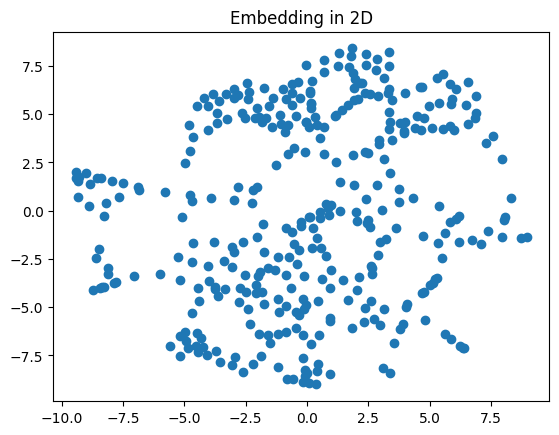

In [51]:
plt.scatter(embedding[:,0], embedding[:,1])
plt.title('Embedding in 2D')
plt.show()